In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
from sklearn.datasets import make_s_curve, make_swiss_roll

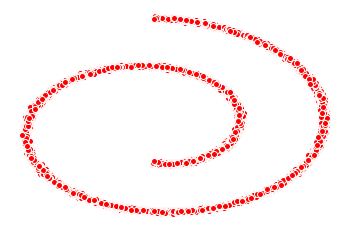

In [2]:
s_curve, _ = make_swiss_roll(10**4, noise = 0.1)
s_curve = s_curve[:, [0,2]]/10.0
#print('shape of moons:', np.shape(s_curve))

data = s_curve.T
fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor = 'white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

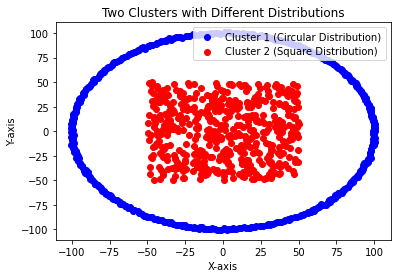

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

size = 500
# Generate random points for the first cluster (circular distribution)
theta1 = np.linspace(0, 2*np.pi, size)
radius1 = 100
cluster1_x = radius1 * np.cos(theta1) + np.random.normal(0, 0.5, size)
cluster1_y = radius1 * np.sin(theta1) + np.random.normal(0, 0.5, size)

# Generate random points for the second cluster (square distribution)
cluster2_x = np.random.uniform(-50, 50, size)
cluster2_y = np.random.uniform(-50, 50, size)

# Plot the clusters
plt.scatter(cluster1_x, cluster1_y, color='blue', label='Cluster 1 (Circular Distribution)')
plt.scatter(cluster2_x, cluster2_y, color='red', label='Cluster 2 (Square Distribution)')

# Add labels and legend
plt.title('Two Clusters with Different Distributions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

In [4]:
num_steps = 1500

betas = torch.linspace(0.0001,0.02, steps = num_steps)
alphas = 1. - betas
alphas_prod = torch.cumprod(alphas, axis=0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

In [5]:
def q_x(x_0,t):
    
    noise = torch.rand_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_l_m_t * noise)

In [6]:
cluster1 = torch.Tensor([[cluster1_x[i], cluster1_y[i]] for i in range(len(cluster1_x))])
cluster2 = torch.Tensor([[cluster2_x[i], cluster2_y[i]] for i in range(len(cluster2_x))])
test_dataset = torch.cat((cluster1, cluster2), dim=0)
test_dataset.size()

torch.Size([1000, 2])

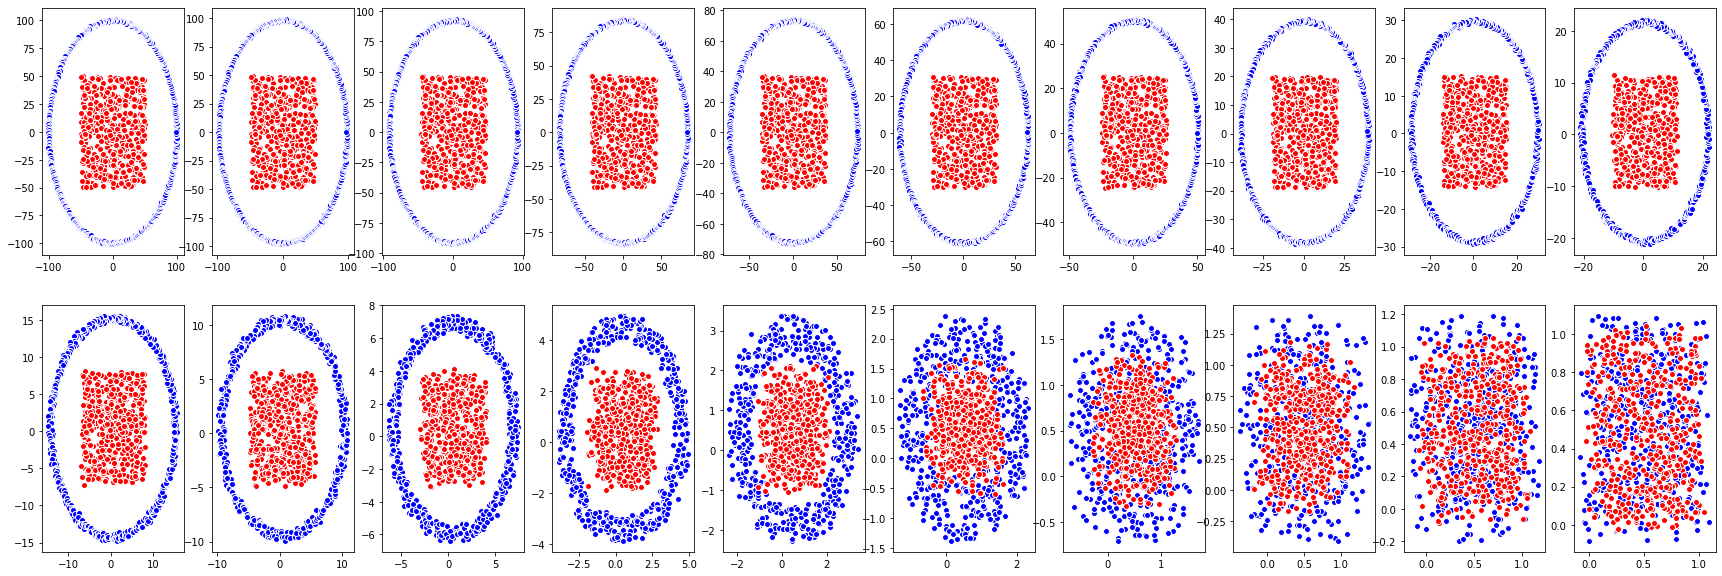

In [7]:
num_shows = 20
fig, axs = plt.subplots(2,10,figsize = (30,10))
plt.rc('text',color = 'blue')

for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(cluster1, torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_i[:,0], q_i[:,1], color = 'blue', edgecolor = 'white')
    q_j = q_x(cluster2, torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_j[:,0], q_j[:,1], color = 'red', edgecolor = 'white')

In [8]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

class MLPDiffusion(nn.Module):
    
    def __init__(self, n_steps, num_units = 128):
        super(MLPDiffusion, self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units,2)
            ]
        )
        
        
        # Time embedding
        self.step_embeddings = nn.Sequential(
                SinusoidalPositionEmbeddings(num_units),
                nn.Linear(num_units, num_units),
                nn.ReLU()
            )
    
    def forward(self, x_0, t):
        
        x = x_0
#         for i, embedding_layer in enumerate(self.step_embeddings):
#             t_embedding = embedding_layer(t)
        for i in range(3):
            x = self.linears[2*i](x)
            x += self.step_embeddings(t)
            x = self.linears[2*i+1](x)
        
        x = self.linears[-1](x)
        
        return x

In [9]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, onw_minus_alphas_bar_sqrt,n_steps):
    
    batch_size = x_0.shape[0]
    
    #t = torch.randint(0, n_steps, size = (batch_size//2,))
    #t = torch.cat([t, n_steps-1-t], dim = 0)
    t = torch.randint(0, n_steps, size = (batch_size,))
    t = t.unsqueeze(-1)
    
    a = alphas_bar_sqrt[t]
    aml = one_minus_alphas_bar_sqrt[t]
    
    e = torch.randn_like(x_0)
    
    x = x_0 * a + e * aml
    output = model(x,t.squeeze(-1))
    
    return (e - output).square().mean()

In [10]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0],x_seq由x[T]、x[T-1]、x[T-2]|...x[0]组成"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z

    sample = mean
    return (sample)

In [11]:
batch_size = 200
dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
num_epoch = 1000

In [ ]:
print('Training model...')
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
      
    
    if(t%100==0):
        print(loss)
#         x_seq = p_sample_loop(model,test_dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)

#         fig,axs = plt.subplots(1,10,figsize=(28,3))
#         for i in range(1,11):
#             cur_x = x_seq[i*10].detach()
#             axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
#             axs[i-1].set_axis_off();
#             axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Training model...


In [ ]:
q_cluster1 = q_x(cluster1, torch.tensor(num_steps - 1))
q_cluster2 = q_x(cluster2, torch.tensor(num_steps - 1))
cluster1_seq = []
cluster2_seq = []
for i in reversed(range(num_steps)):
    q_cluster1 = p_sample(model,q_cluster1,i,betas,one_minus_alphas_bar_sqrt)
    cluster1_seq.append(q_cluster1)
    q_cluster2 = p_sample(model,q_cluster2,i,betas,one_minus_alphas_bar_sqrt)
    cluster2_seq.append(q_cluster2)

In [ ]:
num_shows = 20
fig, axs = plt.subplots(2,10,figsize = (30,10))
plt.rc('text',color = 'blue')
index = np.linspace(0,num_steps,num_shows)
index[-1] -= 1
for i in range(num_shows):
    j = i//10
    k = i%10
    x = cluster1_seq[int(index[i])].detach()
    y = cluster2_seq[int(index[i])].detach()
    axs[j,k].scatter(x[:,0], x[:,1], color = 'red', edgecolor = 'white', alpha = 0.5)
    axs[j,k].scatter(y[:,0], y[:,1], color = 'blue', edgecolor = 'white', alpha = 0.5)